In [ ]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
# Dataset was taken http://mlg.ucd.ie/datasets/bbc.html and preprocessed into a csv format
DATA = "./bbc-text.csv"

# Hyperparameters
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [ ]:
# Loading and pre-processing the data
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    sentence = sentence.lower()
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [ ]:
# Parsing sentences and labels into dedicated arrays
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [ ]:
# Sentences and labels for train/test split
sentences, labels = parse_data_from_file("./bbc-text.csv")

In [ ]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
    train_size = round(len(sentences)*training_split)

    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
# Splitting into train/test sets
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"{len(train_sentences)} sentences for training.\n")
print(f"{len(train_labels)} labels for training.\n")
print(f"{len(val_sentences)} sentences for validation.\n")
print(f"{len(val_labels)} labels for validation.")

1780 sentences for training.

1780 labels for training.

445 sentences for validation.

445 labels for validation.


In [ ]:
# Tokenizer for sentences
def sentences_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [ ]:
sentences_tokenizer = sentences_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)

In [ ]:
# Tokenizer for labels
def labels_tokenizer(all_labels):
    """
    Instantiates the Tokenizer class on all labels

    Args:
        all_labels (list of string): labels to generate the word-index from

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    labels_tokenizer = Tokenizer()
    labels_tokenizer.fit_on_texts(all_labels)

    return labels_tokenizer

In [ ]:
# Use label tokenizer to tokenize the train/test labels (label array) and convert tokenized array into tensor
labels_tokenizer = labels_tokenizer(labels)

train_label_seq = np.array(labels_tokenizer.texts_to_sequences(train_labels))-1
val_label_seq = np.array(labels_tokenizer.texts_to_sequences(val_labels))-1

In [ ]:
# Sequences padding
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)

    return padded_sequences

In [ ]:
# Padd train/test sequences
train_padded_seq = seq_and_pad(train_sentences, sentences_tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, sentences_tokenizer, PADDING, MAXLEN)

In [ ]:
print(f"Tokenized train labels shape: {train_label_seq.shape}\n")
print(f"Tokenized validation labels shape: {val_label_seq.shape}\n")

Tokenized train labels shape: (1780, 1)

Tokenized validation labels shape: (445, 1)



In [ ]:
# Creating classification model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax),
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])


    return model

In [ ]:
# Training the model
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 1s 10ms/step - loss: 1.6075 - accuracy: 0.2163 - val_loss: 1.6055 - val_accuracy: 0.2337
Epoch 2/30
56/56 [==============================] - 0s 7ms/step - loss: 1.5926 - accuracy: 0.3000 - val_loss: 1.5999 - val_accuracy: 0.2562
Epoch 3/30
56/56 [==============================] - 0s 7ms/step - loss: 1.5767 - accuracy: 0.3298 - val_loss: 1.5923 - val_accuracy: 0.2674
Epoch 4/30
56/56 [==============================] - 0s 7ms/step - loss: 1.5570 - accuracy: 0.3511 - val_loss: 1.5825 - val_accuracy: 0.2899
Epoch 5/30
56/56 [==============================] - 1s 10ms/step - loss: 1.5315 - accuracy: 0.3955 - val_loss: 1.5691 - val_accuracy: 0.2944
Epoch 6/30
56/56 [==============================] - 1s 12ms/step - loss: 1.4991 - accuracy: 0.3994 - val_loss: 1.5479 - val_accuracy: 0.3169
Epoch 7/30
56/56 [==============================] - 1s 12ms/step - loss: 1.4581 - accuracy: 0.5169 - val_loss: 1.5187 - val_accuracy: 0.3416
Epoch 8/30
56/56

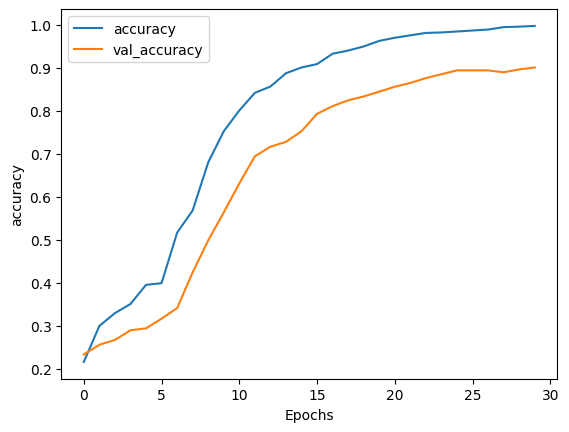

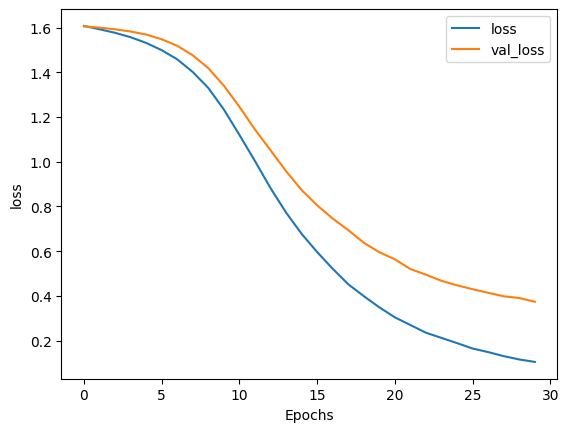

In [ ]:
# Plotting loss/accuracy vs epochs graph
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Model is not perfect, validation accuracy of 95%+ is easily achievable, however 90% is also accaptable.
# Let's visualize the word embeddings and clusters

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in sentences_tokenizer.word_index.items()])
e = model.layers[0]
weights = e.get_weights()[0]
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

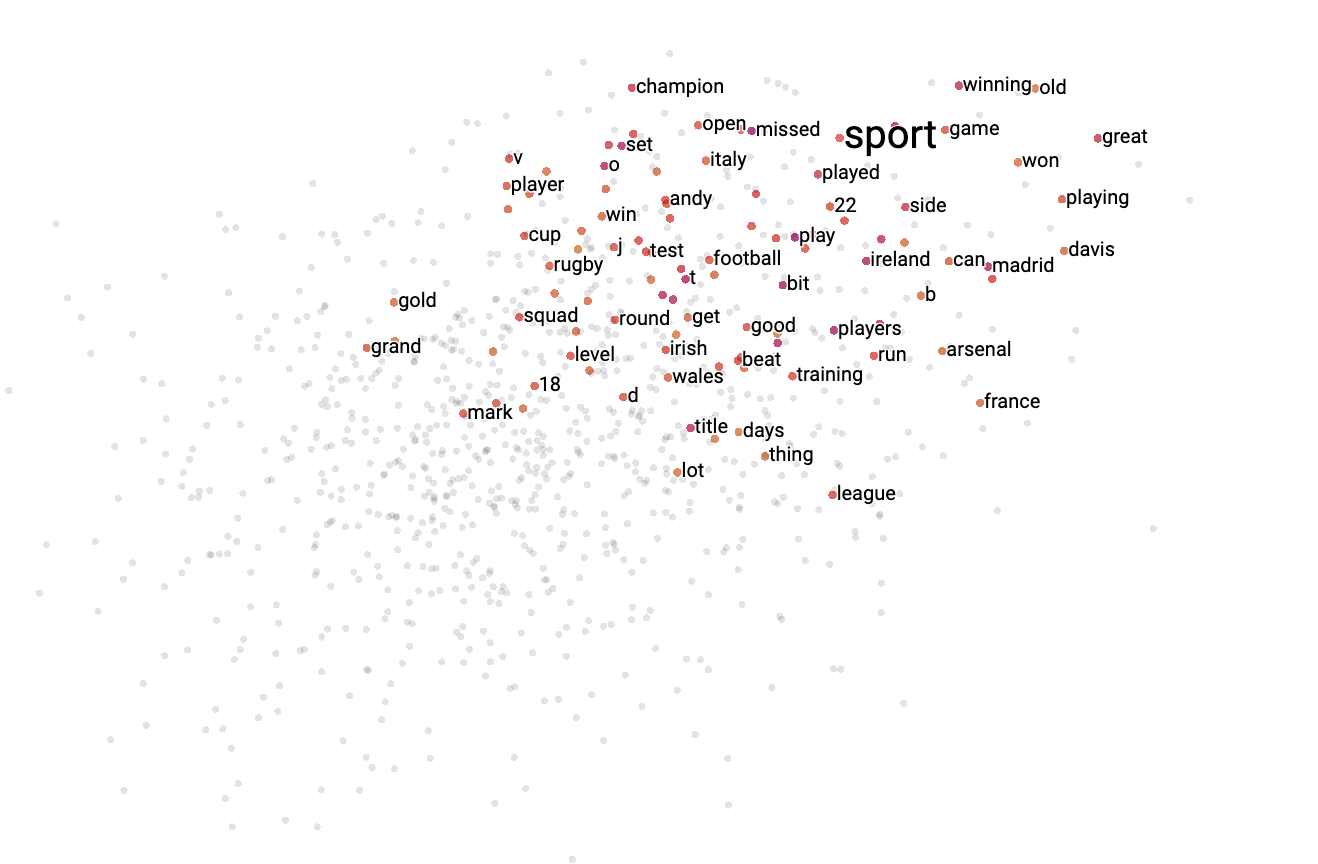

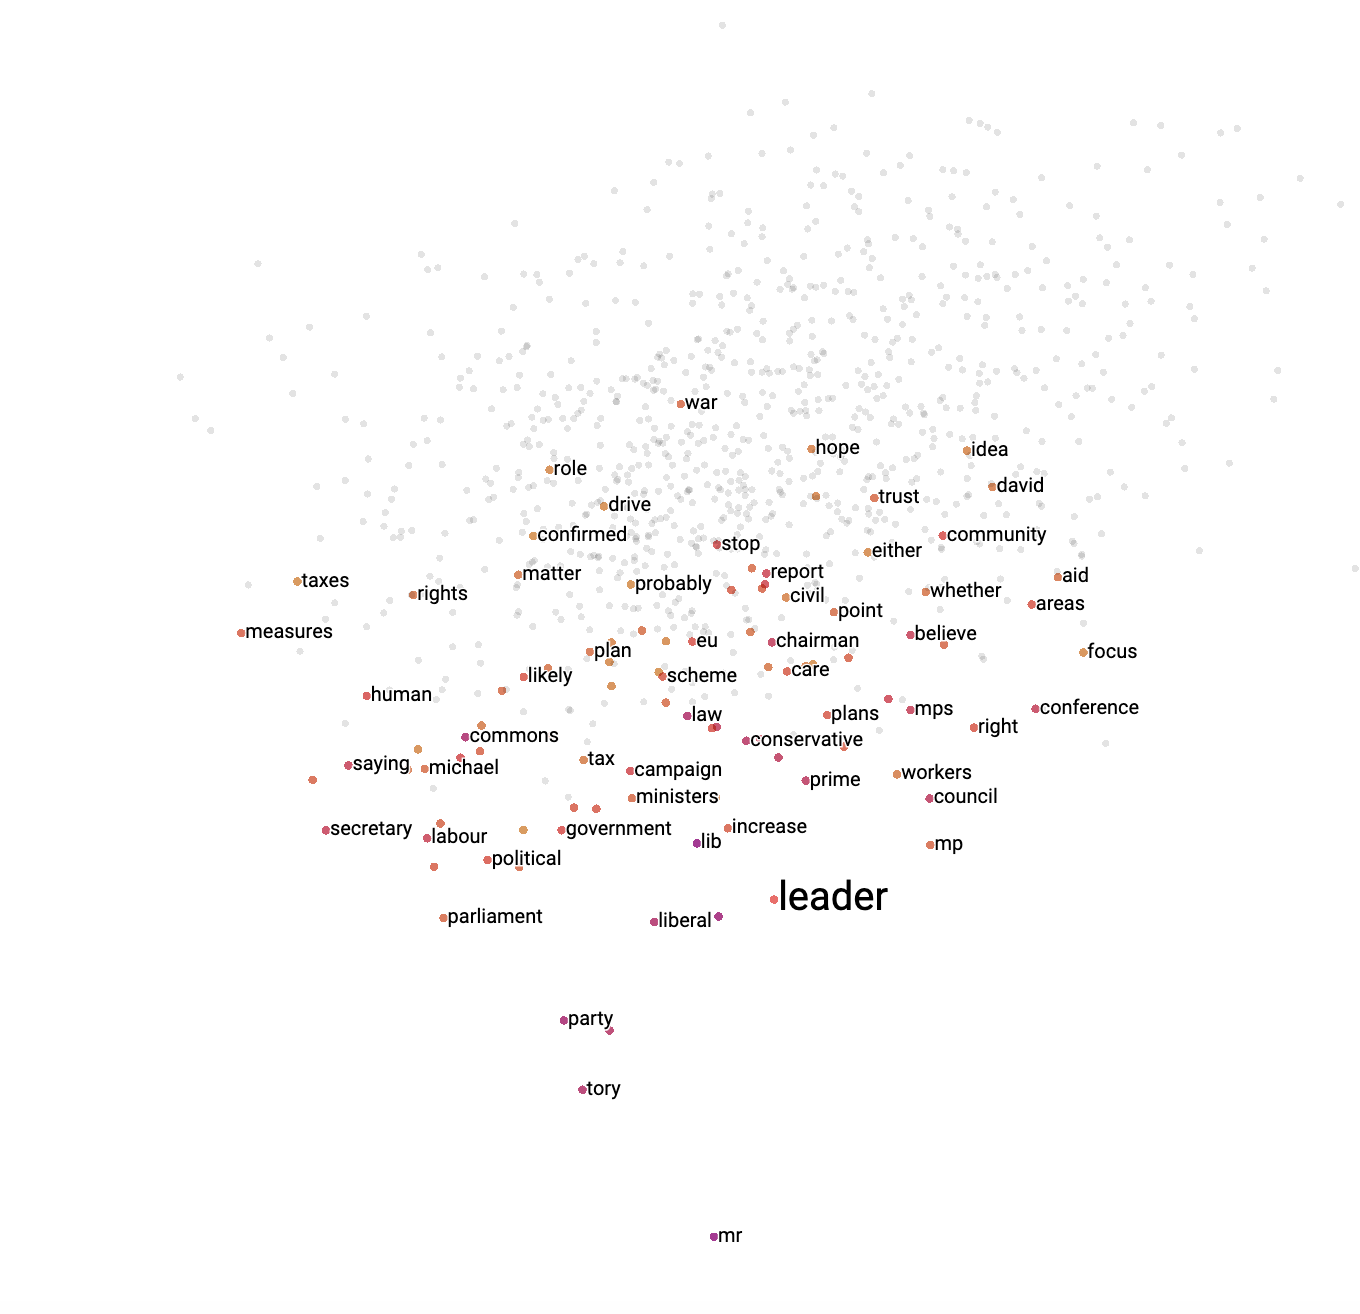